# Analiza Obwodu Elektrycznego
W zadaniu wykorzystamy funkcje z biblioteki numpy, do generowania grafu oraz reprezentowania grafów funkcje z biblioteki networkx a do wizualizacji bibliotekę pyvis.

In [2]:
import numpy as np
import networkx as nx
import pyvis as pv

In [3]:
BLACK = "000000"
LIME = (39, 245, 50)
RED = (82, 3, 8)

#### Funkcje służące do wizualizowania obwodu elektrycznego.

In [4]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [5]:
def get_edge_color(I, max_I, high=RED, low=LIME):
    factor = abs(I) / abs(max_I)
    return rgb_to_hex(tuple([int(low[i] * (1-factor) + high[i] * factor) for i in range(3)]))

In [6]:
def vizualize_electrical_circuit(Graph,I_matrix):
    
    G,sem_dict,res_dict,edge_num = Graph
    vertices_number = G.number_of_nodes()
    max_I = max(max(I_matrix)[0],abs(min(I_matrix)[0]))
    vis = pv.network.Network(directed=True)
    

    vis.add_nodes([i for i in range(vertices_number)],
            title=["Vertex " + str(i) for i in range(vertices_number)],
            size=[5 for _ in range(vertices_number)], color=[BLACK for _ in range(vertices_number)])
    
    for edge in G.edges():
        edge = (min(edge[0],edge[1]),max(edge[0],edge[1]))
        index = edge_num[edge]
        I = I_matrix[index,0]
        info = "R=%.2f" % res_dict[edge]
        change = False
        
        if I <= 0:
            info += " I=%.2f" % -I_matrix[index,0]
            change = True
        else:
            info += " I=%.2f" % I_matrix[index,0]

        if edge in sem_dict.keys():
            info += " U=%.2f" % sem_dict[edge]

        color = get_edge_color(I,max_I)

        if change:
            vis.add_edge(edge[1],edge[0],title=info, label=info, color=color,length=200)
        else:
            vis.add_edge(edge[0],edge[1],title=info, label=info, color=color,length=200)
    
    vis.show("graph.html",notebook=False)


#### Funkcje służace do wczytywania oraz zapisywania grafu do pliku.

In [7]:
def load_graph(filename):

    res_dict = {}
    sem_dict = {}
    edge_num = {}
    G = nx.empty_graph()
    
    with open(filename,'r') as file:
        for full_line in file:
            line = full_line.split()
            edge = (min(int(line[0]),int(line[1])),max(int(line[0]),int(line[1])))
            G.add_edge(edge[0],edge[1])
            res_dict[edge] = int(line[2])
            if len(line) == 4:
                sem_dict[edge] = int(line[3])

    i = 0
    for e in G.edges():
        edge = (min(e[0],e[1]),max(e[0],e[1]))
        edge_num[edge] = i
        i += 1

    return G,sem_dict,res_dict,edge_num


In [8]:
def save_graf(Graph,filename):
    G,sem_dict,res_dict,edge_num = Graph
    with open(filename,'w') as file:
        for e in G.edges():
            edge = (min(e[0],e[1]),max(e[0],e[1]))
            line = "%i %i" % edge
            line += " %i" % res_dict[edge]
            if edge in sem_dict.keys():
                line += " %i" % sem_dict[edge]
            file.write(line + '\n')

    

#### Poniżej znajdują się funkcje generujące grafy.

Funkcje generują kolejno grafy:
* Spójny graf losowy (Erdos-Renyi)
* Graf 3-regularny (Kubiczny)
* Graf złożony zdwóch grafów losowych połączonych mostkiem
* Graf siatka 2D
* Graf typu small-world

In [9]:
def generate_erdos_renyi_graph(n,p,resistance_min=1,resistance_max=10,source_number=3,SEM_min=1,SEM_max=10):
    G = nx.erdos_renyi_graph(n,p)
    edges = G.number_of_edges()

    res_dict = {}
    sem_dict = {}
    edge_num = {}
    SEM_index = np.arange(edges)
    np.random.shuffle(SEM_index)
    SEM_index = SEM_index[:source_number]
    i = 0
    for u,v in G.edges():
        res_dict[(u,v)] = np.random.randint(resistance_min,resistance_max)
        if i in SEM_index:
            sem_dict[(u,v)] = np.random.randint(SEM_min,SEM_max)
        edge_num[(u,v)] = i
        i += 1
    
    return G,sem_dict,res_dict,edge_num


In [10]:
def third_regular_graph(n,resistance_min=1,resistance_max=10,source_number=3,SEM_min=1,SEM_max=10):
    G = nx.random_regular_graph(3,n)
    edges = G.number_of_edges()

    res_dict = {}
    sem_dict = {}
    edge_num = {}
    SEM_index = np.arange(edges)
    np.random.shuffle(SEM_index)
    SEM_index = SEM_index[:source_number]
    i = 0
    for e in G.edges():
        edge = (min(e[0],e[1]),max(e[0],e[1]))
        res_dict[edge] = np.random.randint(resistance_min,resistance_max)
        if i in SEM_index:
            sem_dict[edge] = np.random.randint(SEM_min,SEM_max)
        edge_num[edge] = i
        i += 1
    
    return G,sem_dict,res_dict,edge_num

In [11]:
def bridge_graph(n1,n2,p1,p2,bridges,resistance_min=1,resistance_max=10,source_number=3,SEM_min=1,SEM_max=10):
    G1 = nx.erdos_renyi_graph(n1,p1)
    G2 = nx.erdos_renyi_graph(n2,p2)
    G = nx.empty_graph()

    for u,v in G1.edges():
        G.add_edge(u,v)
    
    for u,v in G2.edges():
        G.add_edge(u+n1,v+n1)

    for _ in range(bridges):
        point1 = np.random.randint(0,n1)
        point2 = np.random.randint(n1,n1+n2)
        G.add_edge(point1,point2)

    res_dict = {}
    sem_dict = {}
    edge_num = {}
    SEM_index = np.arange(G.number_of_edges())
    np.random.shuffle(SEM_index)
    SEM_index = SEM_index[:source_number]

    i = 0
    for e in G.edges:
        edge = (min(e[0],e[1]),max(e[0],e[1]))
        res_dict[edge] = np.random.randint(resistance_min,resistance_max)
        if i in SEM_index:
            sem_dict[edge] = np.random.randint(SEM_min,SEM_max)
        edge_num[edge] = i
        i += 1

    return G,sem_dict,res_dict,edge_num     

In [12]:
def grid_graph(n,m,resistance_min=1,resistance_max=10,source_number=3,SEM_min=1,SEM_max=10):
    Gx = nx.grid_2d_graph(m,n)
    edges = Gx.number_of_edges()
    G = nx.empty_graph()
    res_dict = {}
    sem_dict = {}
    edge_num = {}
    SEM_index = np.arange(edges)
    np.random.shuffle(SEM_index)
    SEM_index = SEM_index[:source_number]
    i = 0
    for e in Gx.edges():
        p1 = e[0][0]*n+e[0][1]
        p2 = e[1][0]*n+e[1][1]
        edge = (min(p1,p2),max(p1,p2))
        G.add_edge(min(p1,p2),max(p1,p2))
        res_dict[edge] = np.random.randint(resistance_min,resistance_max)
        if i in SEM_index:
            sem_dict[edge] = np.random.randint(SEM_min,SEM_max)
        edge_num[edge] = i
        i += 1
    
    return G,sem_dict,res_dict,edge_num

In [13]:
def generate_small_world_graph(n,k,p,resistance_min=1,resistance_max=10,source_number=3,SEM_min=1,SEM_max=10):
    G = nx.watts_strogatz_graph(n,k,p)
    edges = G.number_of_edges()

    res_dict = {}
    sem_dict = {}
    edge_num = {}
    SEM_index = np.arange(edges)
    np.random.shuffle(SEM_index)
    SEM_index = SEM_index[:source_number]
    i = 0
    for u,v in G.edges():
        res_dict[(u,v)] = np.random.randint(resistance_min,resistance_max)
        if i in SEM_index:
            sem_dict[(u,v)] = np.random.randint(SEM_min,SEM_max)
        edge_num[(u,v)] = i
        i += 1
    
    return G,sem_dict,res_dict,edge_num

#### Funkcja wyznacza równanie z I prawa Kirchoffa 

In [14]:
def vertex_equation(ind,G,vertex):
    N = G.number_of_edges()
    equation = np.zeros(N+1)
    for e in G.edges(vertex):
        edge = (min(e),max(e))
        index = ind[edge]
        if e[0] < e[1]:
            equation[index] = 1
        else:
            equation[index] = -1
    
    return equation

#### Funkcja wyznacza równanie z II prawa Kirchoffa

In [15]:
def cycle_equation(res,sem,ind,G,cycle):
    N = G.number_of_edges()
    equation = np.zeros(N+1)
    for i in range(len(cycle)):
        i = i % len(cycle)
        j = (i+1) % len(cycle)
        e = (cycle[i],cycle[j])
        edge = (min(cycle[i],cycle[j]),max(cycle[i],cycle[j]))
        
        if edge in sem.keys():
            equation[N] = equation[N] - sem[edge]

        index = ind[edge]

        if e[0] < e[1]:
            equation[index] = res[edge]
        else:
            equation[index] = -res[edge]
    
    return equation

#### Funkcja solve wyznacza natężenia płynące przez obwód elektryczny

Graf posiada V wierzchołków i E krawędzi \
Funkcja wyznacza V-1 równań z pierwszego prawa Kirchoffa i E-V+1 równań z drugiego prawa Kirchoffa \
Dzięki funkcji z biblioteki networkx cycle_basis otrzymujemy E-V+1 niezależnych cykli, które dają nam wystarczająco wiele informacji aby rozwiązać układ równań. Funkcja poniżej rozwiązuje układ określony. Macierz uzyskana przez funkcję ma E wiersz oraz E+1 klolumn gdzie kolumna o indeksie E zawiera wyniki równań.  \
Początkowo zakładamy, że prąd płynie od wierzchołka o mniejszym indeksie do wierzchołka o większym. Jeżeli natężenie prądu płynące przez krawędź jest ujemne oznacza to, że prąd płynie z wierzchołka o indeksie większym do wierzchołka o indeksie mniejszym.  \
Graf jest reprezentowany w postaci: graf z biblioteki networkx, słownik oporów (każdej krawędzi przyporządkowuje wartość opóru), słownik SEM (kluczami są krawędzie, na których występują źródła SEM oraz ich wartości) i słownik indeksów (każdej krawędzi przyporządkowuje indeks wartości z układu współrzędnych). \
Wyznaczony przez nas układ równań jest rozwiązywany przez funkcję z biblioteki numpy. \
Gdybyśmy mieli doczynienia z nadokreślony układem równań możemy skorzystać z elminacji Gaussa do wyznaczenia układu równań niezależnych.

In [16]:
def solve(Graph):

    G,sem_dict,res_dict,edge_num = Graph
    cycles = nx.cycle_basis(G)
    arr = []
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()

    for i in range(nodes-1):
        arr.append(vertex_equation(edge_num,G,i))

    for cycle in cycles:
        arr.append(cycle_equation(res_dict,sem_dict,edge_num,G,cycle))

    mat = np.matrix(arr)

    return np.linalg.solve(mat[:,:edges],mat[:,edges])
    

#### Funkcja sprawdza rozwiązanie 
Wykorzystując pierwsze prawo Kirchoffa sprawdza czy suma prądów wchodzących i wychodzących z każdego wierzchołka jest równa zero.

In [17]:
def check_answer(Graph,eps = 10**(-12)):
    
    G,sem_dict,res_dict,edge_num = Graph
    I_matrix = solve(Graph)
    
    for vertex in range(G.number_of_nodes()):

        sum = 0
        for e in G.edges(vertex):
            edge = (min(e),max(e))
            index = edge_num[edge]
            if e[0] < e[1]:
                sum += I_matrix[index,0]
            else:
                sum -= I_matrix[index,0]

        if abs(sum) > eps:
            print(abs(sum))
            return False
    
    return True
            

In [18]:
def check_all_types():
    size = [30,50,100,200]
    for number_of_nodes in size:
        print("Erdos_renyi_graph test graph size: "+str(number_of_nodes),end=": ")
        print(check_answer(generate_erdos_renyi_graph(number_of_nodes,0.6)))
        print("Third_regular_graph test graph size: "+str(number_of_nodes),end=": ")
        print(check_answer(third_regular_graph(number_of_nodes)))
        print("Bridge_graph test graph size: "+str(number_of_nodes),end=": ")
        print(check_answer(bridge_graph(number_of_nodes//2,number_of_nodes//2,0.6,0.6,3)))
        print("Grid_graph test graph size: "+str(number_of_nodes),end=": ")
        print(check_answer(grid_graph(number_of_nodes//2,number_of_nodes//2)))
        print("Small_world_graph test graph size: "+str(number_of_nodes),end=": ")
        print(check_answer(generate_small_world_graph(number_of_nodes,5,0.6)))

        

In [872]:
check_all_types()

Erdos_renyi_graph test graph size: 30: True
Third_regular_graph test graph size: 30: True
Bridge_graph test graph size: 30: True
Grid_graph test graph size: 30: True
Small_world_graph test graph size: 30: True
Erdos_renyi_graph test graph size: 50: True
Third_regular_graph test graph size: 50: True
Bridge_graph test graph size: 50: True
Grid_graph test graph size: 50: True
Small_world_graph test graph size: 50: True
Erdos_renyi_graph test graph size: 100: True
Third_regular_graph test graph size: 100: True
Bridge_graph test graph size: 100: True
Grid_graph test graph size: 100: True
Small_world_graph test graph size: 100: True
Erdos_renyi_graph test graph size: 200: True
Third_regular_graph test graph size: 200: True
Bridge_graph test graph size: 200: True
Grid_graph test graph size: 200: True
Small_world_graph test graph size: 200: True


#### Graf losowy

In [19]:
G1 = generate_erdos_renyi_graph(10,0.5)
I_matrix = solve(G1)
vizualize_electrical_circuit(G1,I_matrix)

graph.html


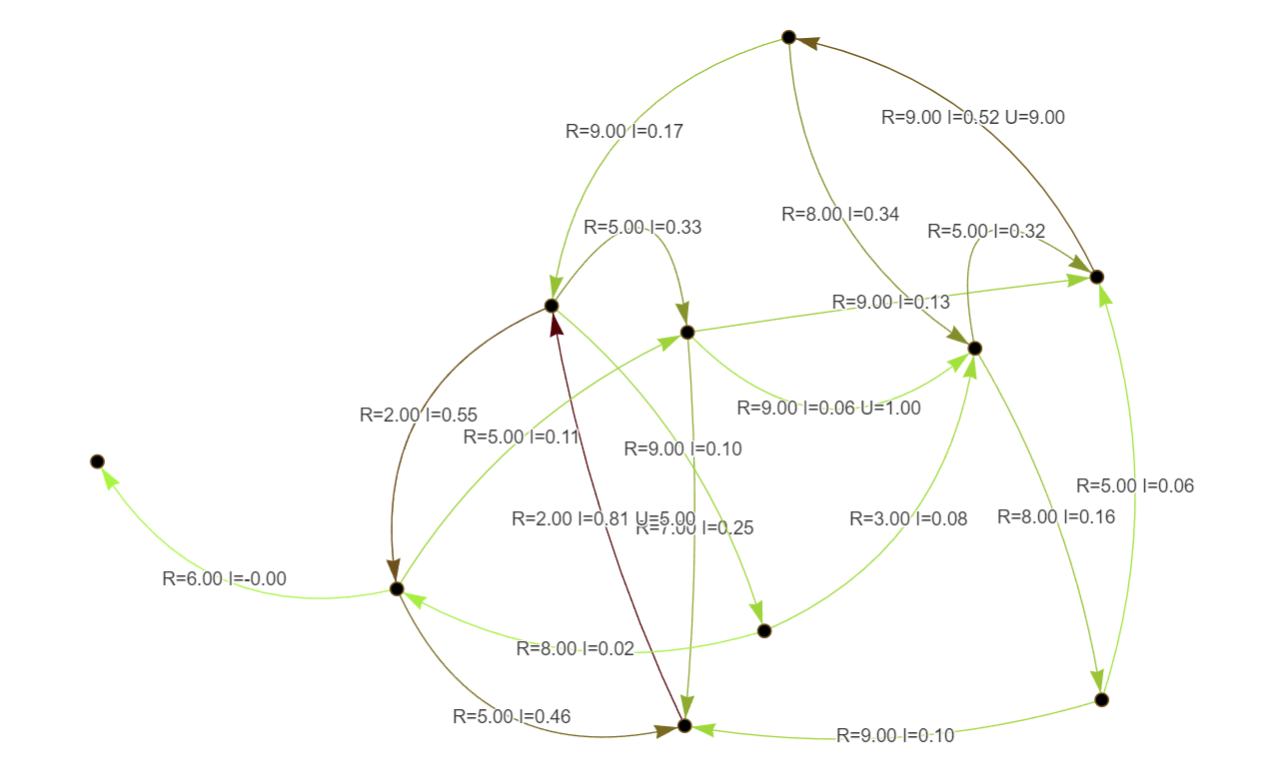

#### Graf 3-regularny

In [875]:
G2 = third_regular_graph(10)
I_matrix = solve(G1)
vizualize_electrical_circuit(G1,I_matrix)

graph.html


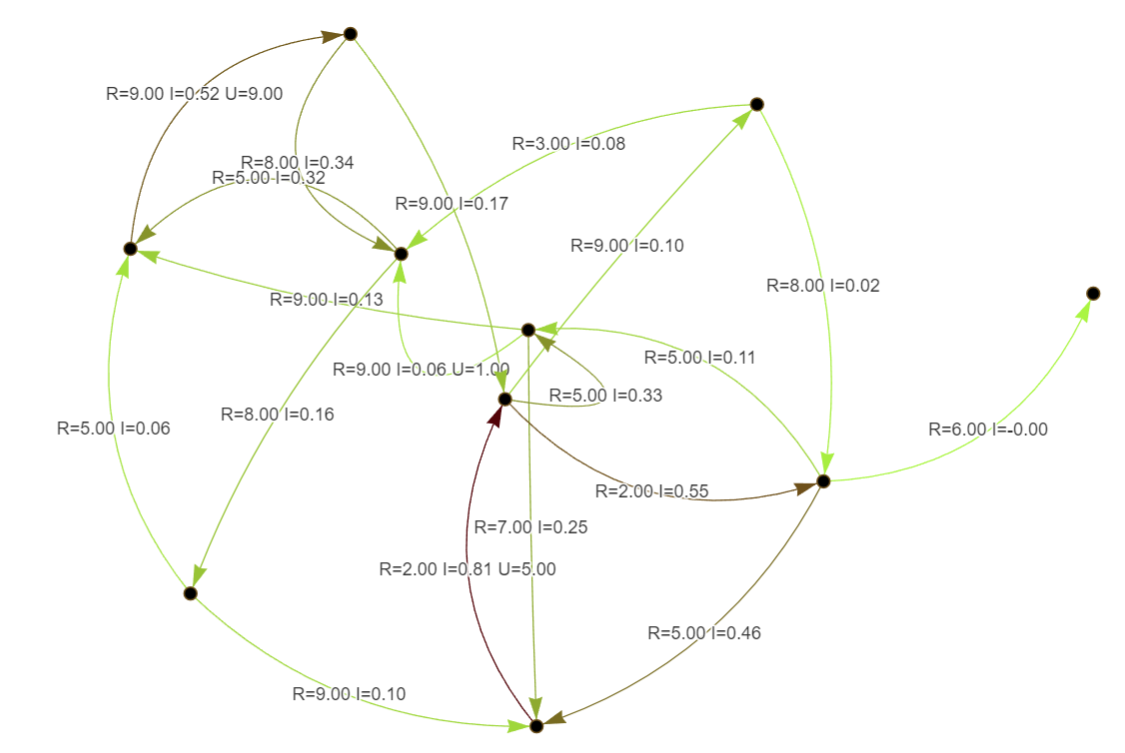

#### Graf złożony z dwóch grafów losowych połączonych mostkiem

In [876]:
G3 = bridge_graph(8,8,0.6,0.5,2)
I_matrix = solve(G3)
vizualize_electrical_circuit(G3,I_matrix)

graph.html


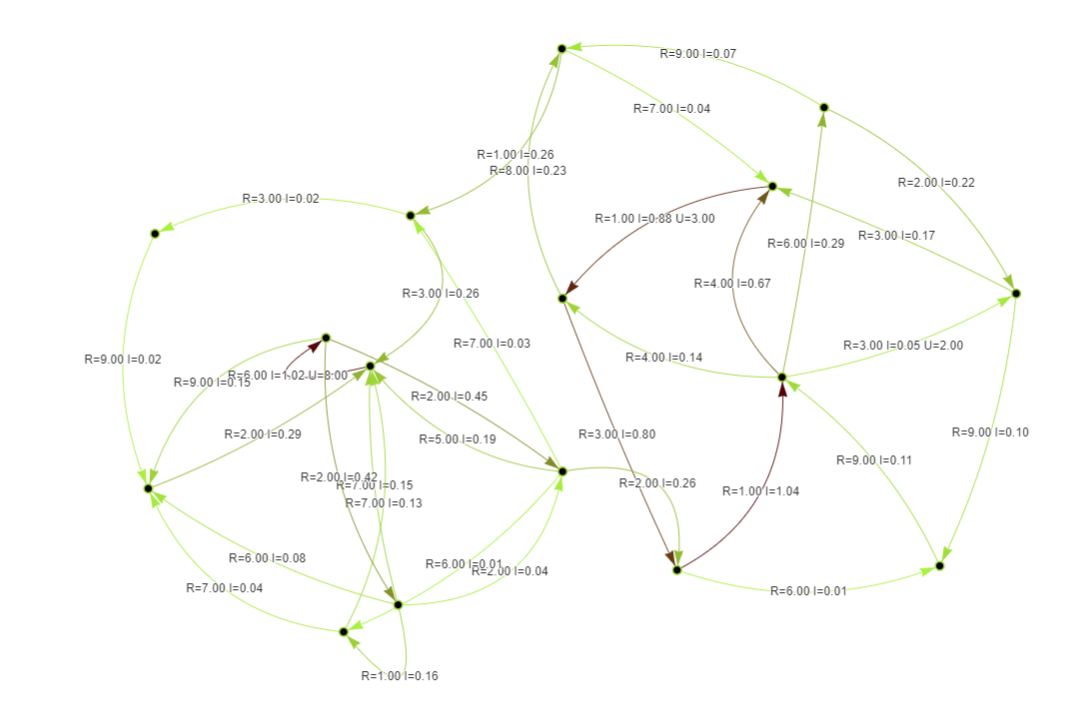

#### Graf siatka 2D

In [883]:
G4 = grid_graph(6,6)
I_matrix = solve(G4)
vizualize_electrical_circuit(G4,I_matrix)

graph.html


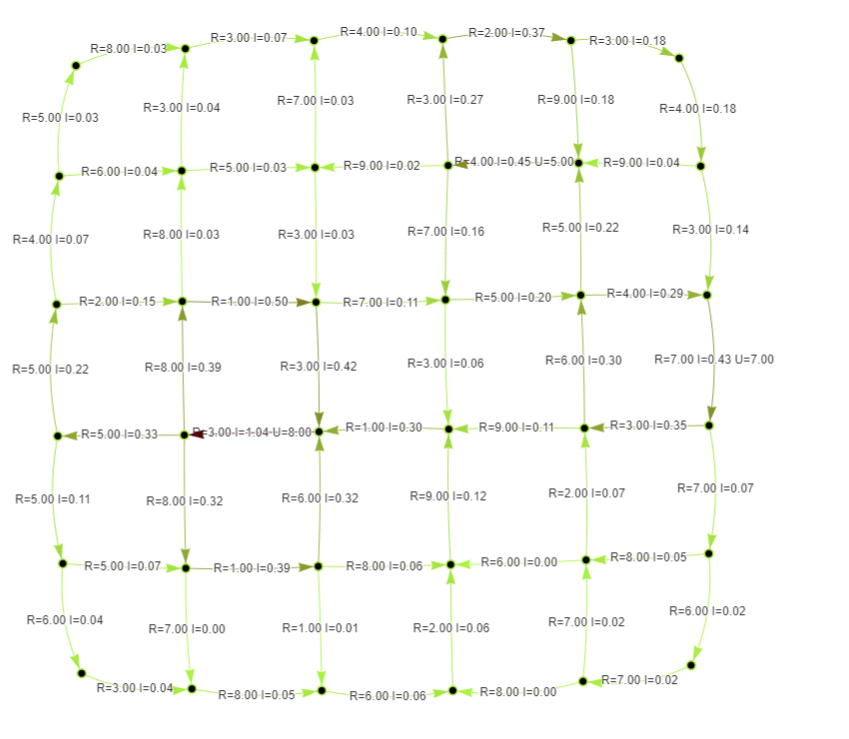

#### Graf typu small-world

In [888]:
G5 = generate_small_world_graph(10,4,0.6)
I_matrix = solve(G5)
vizualize_electrical_circuit(G5,I_matrix)

graph.html


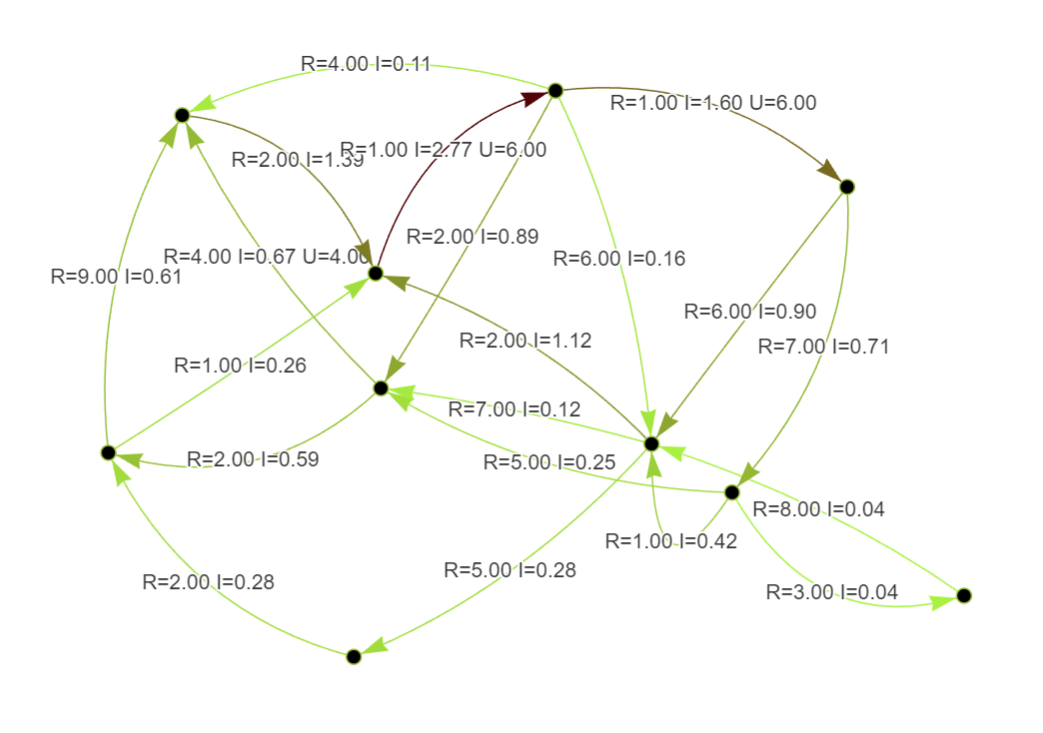